In [7]:
import sys
sys.path.append('CLIP-dissect') 

In [8]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import cv2
import glob
import random
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib
import similarity
import utils
import data_utils
import clip
from sentence_transformers import SentenceTransformer

%matplotlib inline

In [9]:
dataset_path = "FER2013"
class_names = os.listdir(dataset_path+"/train")
print(class_names)

['disgust', 'happy', 'angry', 'neutral', 'sad', 'surprise', 'fear']


In [10]:
emotions = []
for file_name in glob.glob(dataset_path+'/train/*/*'):
    emotion = file_name.split('/')[-2]
    if emotion not in emotions:
        img = cv2.imread(file_name)
    emotions.append(emotion)
    
emotions = []
for file_name in glob.glob(dataset_path+'/test/*/*'):
    emotion = file_name.split('/')[-2]
    if emotion not in emotions:
        img = cv2.imread(file_name)
    emotions.append(emotion)

In [11]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((48,48))])

train_dataset = ImageFolder(dataset_path+'/train',transform)
train_loader = DataLoader(dataset=train_dataset,batch_size=100*6)
#creating val data loaders
val_dataset = ImageFolder(dataset_path+'/test',transform)
val_loader = DataLoader(dataset=val_dataset,batch_size=100)

In [12]:
clip_name = 'ViT-B/16'
device = 'cuda'
batch_size = 30
model = SentenceTransformer('all-mpnet-base-v2')
clip_model, _ = clip.load(clip_name, device=device)
clip_cos, mp_cos = utils.get_cos_similarity('sad', ['angry', 'happy'], 
                                           clip_model, model, device, batch_size)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
from clip_dissect_pipeline import dissect_pipeline

In [14]:
import models
model_path = 'VGGNet'
checkpoint = torch.load(model_path)
target_model = models.Vgg()
target_model.load_state_dict(checkpoint["params"])
target_model

Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

In [20]:
with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')
words

['Furrowed Brows',
 'Raised Brows',
 'Lowered Brows',
 'Drooping Brows',
 'Relaxed Brows',
 'Wide Open Eyes',
 'Narrowed Eyes',
 'Twinkling or Crinkled Eyes',
 'Tearful Eyes',
 'Closed Eyes',
 'Relaxed Eyes',
 'Tense Mouth and Jaw',
 'Relaxed Mouth and Jaw',
 'Smile',
 'Frown',
 'Downturned Mouth',
 'Slightly Open Mouth',
 'Wide Open Mouth',
 'Slight Chin Raise',
 'Slightly Dropped Jaw',
 'Flared Nostrils',
 'Tightened Facial Muscles',
 'Compressed Lips',
 'Elevated Upper Eyelids',
 'Relaxed Facial Muscles']

In [35]:
from prettytable import PrettyTable 
 
# Specify the Column Names while initializing the Table 
myMPTable = PrettyTable([''] + class_names)
myCLIPTable = PrettyTable([''] + class_names)
embedding_model = SentenceTransformer('all-mpnet-base-v2')
clip_name = 'ViT-B/16'
clip_model, _ = clip.load(clip_name, device=device)

for word in words:
    row1 = []
    row2 = []
    for class_name in class_names:
        clip_cos, mp_cos = utils.get_cos_similarity([class_name], [word], 
                                           clip_model, embedding_model, device, batch_size)
        row1.append(str(round(mp_cos, 2)))
        row2.append(str(round(clip_cos, 2)))
    myMPTable.add_row([word] + row1)
    myCLIPTable.add_row([word] + row2)
print(myMPTable)
print(myCLIPTable)

+----------------------------+---------+-------+-------+---------+------+----------+------+
|                            | disgust | happy | angry | neutral | sad  | surprise | fear |
+----------------------------+---------+-------+-------+---------+------+----------+------+
|       Furrowed Brows       |   0.35  |  0.2  |  0.34 |   0.15  | 0.2  |   0.1    | 0.29 |
|        Raised Brows        |   0.27  |  0.2  |  0.31 |   0.11  | 0.17 |   0.09   | 0.25 |
|       Lowered Brows        |   0.19  |  0.15 |  0.15 |   0.14  | 0.17 |   0.06   | 0.17 |
|       Drooping Brows       |   0.14  |  0.13 |  0.12 |   0.04  | 0.14 |   0.01   | 0.15 |
|       Relaxed Brows        |   0.12  |  0.16 |  0.09 |   0.13  | 0.06 |   0.02   | 0.14 |
|       Wide Open Eyes       |   0.28  |  0.26 |  0.32 |   0.23  | 0.18 |   0.3    | 0.3  |
|       Narrowed Eyes        |   0.43  |  0.26 |  0.41 |   0.22  | 0.27 |   0.22   | 0.37 |
| Twinkling or Crinkled Eyes |   0.15  |  0.15 |  0.19 |   0.05  | 0.13 |   0.09

In [33]:
clip_cos, mp_cos = utils.get_cos_similarity(['happy'], ['happy'], 
                                           clip_model, embedding_model, device, batch_size=1)
clip_cos, mp_cos

(1.0, 1.0)

In [15]:
d_probe = 'FER2013'
concept_set = 'CLIP-dissect/data/concept_set.txt' # concept set needs to be path to .txt file
similarity_fn = similarity.soft_wpmi
target_name = 'deep_emotion'
target_layer = 'conv4b'


  0%|          | 0/574 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

 99%|█████████▉| 569/574 [00:10<00:00, 76.04it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabli

100%|██████████| 512/512 [00:00<00:00, 2929.40it/s]


torch.Size([512, 24])


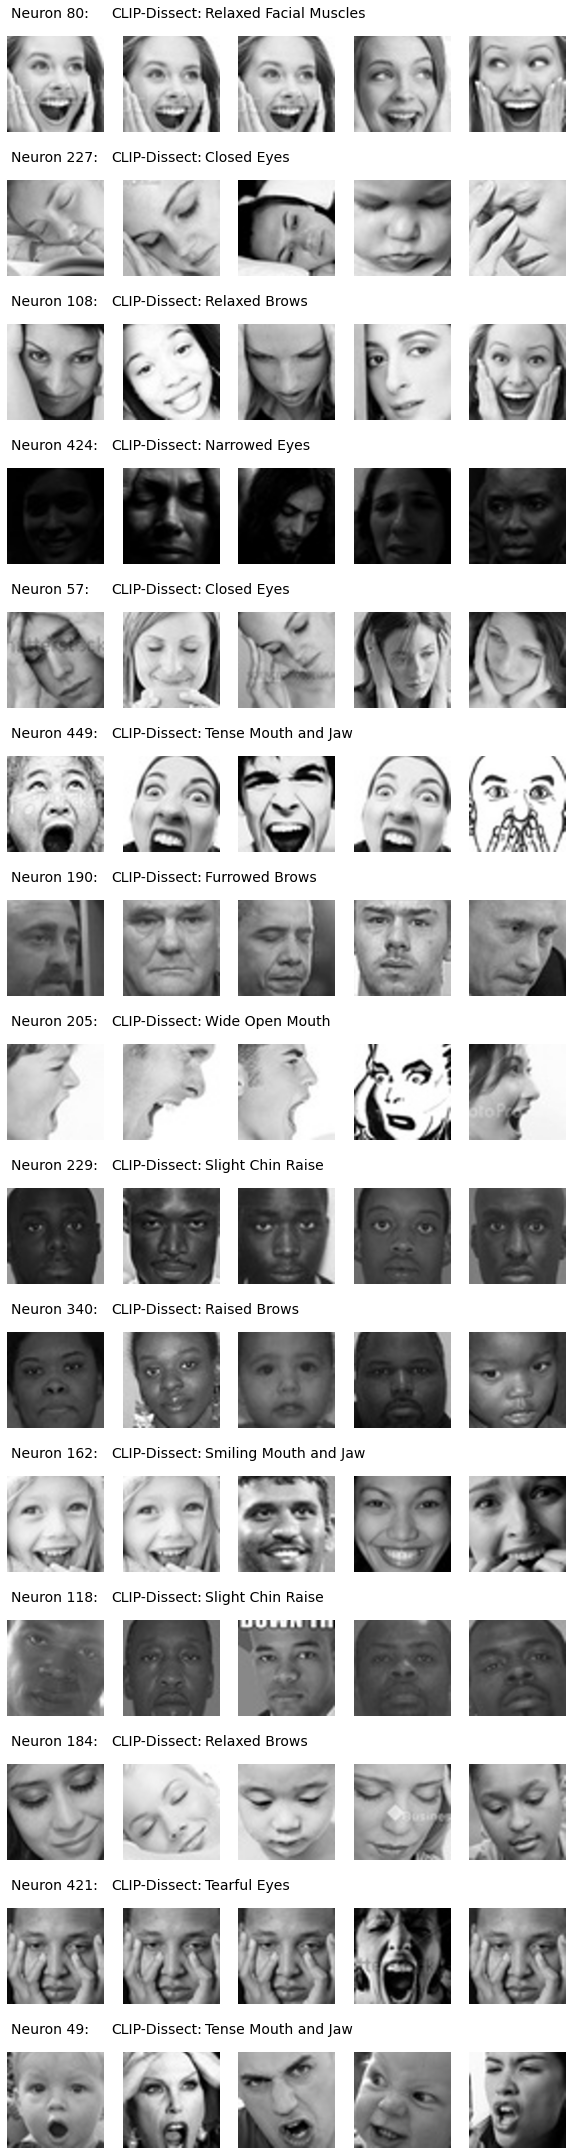

In [16]:
# Need to change dataset path and dataset in data_utils.py in order to run your wanted CLIP-dissect with image
predicted_emotions, neuron_image_indices = dissect_pipeline(d_probe,concept_set, similarity_fn, target_name, target_layer)


In [17]:
predicted_emotions, neuron_image_indices

(['Relaxed Facial Muscles',
  'Closed Eyes',
  'Relaxed Brows',
  'Narrowed Eyes',
  'Closed Eyes',
  'Tense Mouth and Jaw',
  'Furrowed Brows',
  'Wide Open Mouth',
  'Slight Chin Raise',
  'Raised Brows',
  'Smiling Mouth and Jaw',
  'Slight Chin Raise',
  'Relaxed Brows',
  'Tearful Eyes',
  'Tense Mouth and Jaw'],
 {tensor(80, device='cuda:0'): [28437, 15320, 27980, 27979, 28620],
  tensor(227, device='cuda:0'): [16950, 21695, 23417, 21106, 5103],
  tensor(108, device='cuda:0'): [6535, 12957, 8121, 15715, 13677],
  tensor(424, device='cuda:0'): [9290, 20980, 24545, 22433, 18347],
  tensor(57, device='cuda:0'): [22516, 14943, 24531, 4729, 22010],
  tensor(449, device='cuda:0'): [8132, 7650, 7243, 7575, 7227],
  tensor(190, device='cuda:0'): [5060, 25427, 24445, 22188, 3060],
  tensor(205, device='cuda:0'): [493, 3910, 3578, 6262, 6771],
  tensor(229, device='cuda:0'): [18714, 15907, 17797, 16419, 20133],
  tensor(340, device='cuda:0'): [15832, 20486, 16612, 19719, 17825],
  tensor(1

In [18]:
from collections import Counter

def get_actual_labels(image_indices, pil_data):
    labels = []
    for idx in image_indices:
        path, _ = pil_data.samples[idx]
        label = path.split('/')[-2]  
        labels.append(label)
    return labels

In [19]:
detailed_results = {}
pil_data = data_utils.get_data(d_probe)
for neuron, predicted_emotion in zip(neuron_image_indices.keys(), predicted_emotions):
    neuron_id = neuron
    image_indices = neuron_image_indices[neuron]
    actual_labels = get_actual_labels(image_indices, pil_data)
    
    detailed_results[neuron_id] = {
        'predicted_emotion': predicted_emotion,
        'actual_labels': actual_labels,
        'top_image_indices': image_indices,
    }

    correct_count = actual_labels.count(predicted_emotion)
    
    # Calculate the accuracy for this neuron
    accuracy = correct_count / len(image_indices)
    detailed_results[neuron_id]['accuracy'] = accuracy

# cos and mp sim between labels
embedding_model = SentenceTransformer('all-mpnet-base-v2')
clip_name = 'ViT-B/16'
clip_model, _ = clip.load(clip_name, device=device)
# Calculate overall accuracy
overall_accuracy = sum(d['accuracy'] for d in detailed_results.values()) / len(detailed_results)

# Print the detailed results
for neuron_id, results in detailed_results.items():
    print(f"Neuron {neuron_id}: Predicted Emotion = {results['predicted_emotion']}, Accuracy = {results['accuracy']}")
    for image_idx, actual_label in zip(results['top_image_indices'], results['actual_labels']):
        clip_cos, mp_cos = utils.get_cos_similarity(results['predicted_emotion'], actual_label, 
                                           clip_model, embedding_model, device, batch_size)
        print(f"    Image Index {image_idx}: Actual Label = {actual_label}, mp_cos similarity = {mp_cos}")
print(f"Overall accuracy: {overall_accuracy}")

Neuron 80: Predicted Emotion = Relaxed Facial Muscles, Accuracy = 0.0
    Image Index 28437: Actual Label = surprise, mp_cos similarity = 0.10923577845096588
    Image Index 15320: Actual Label = happy, mp_cos similarity = 0.1035609245300293
    Image Index 27980: Actual Label = surprise, mp_cos similarity = 0.10923577845096588
    Image Index 27979: Actual Label = surprise, mp_cos similarity = 0.10923577845096588
    Image Index 28620: Actual Label = surprise, mp_cos similarity = 0.10923577845096588
Neuron 227: Predicted Emotion = Closed Eyes, Accuracy = 0.0
    Image Index 16950: Actual Label = neutral, mp_cos similarity = 0.23792298138141632
    Image Index 21695: Actual Label = sad, mp_cos similarity = 0.2120683640241623
    Image Index 23417: Actual Label = sad, mp_cos similarity = 0.2120683640241623
    Image Index 21106: Actual Label = sad, mp_cos similarity = 0.2120683640241623
    Image Index 5103: Actual Label = fear, mp_cos similarity = 0.24189665913581848
Neuron 108: Predic